### 1D VELOCITY MODELS MESH

In [2]:
#Create mesh
from obspy.geodetics import degrees2kilometers
from obspy.geodetics import kilometers2degrees
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import obspy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from obspy.taup import TauPyModel
from obspy.taup import taup_create

#model = TauPyModel(model="iasp91")
model = TauPyModel(model="japan_1d")
#model = TauPyModel(model="pavdut")
#model = TauPyModel(model = 'ak135')

#print(degrees2kilometers(1))


depth_min = 0 #kilometers
depth_max = 300 #kilometers, 100
num_dep = 60
num_dist = num_dep
dist_min = 0 # kilometers
dist_max = 250 #kilometers

depth_vec = np.linspace(depth_min,depth_max,num_dep)

dist_vec = np.linspace(dist_min,dist_max,num_dist)

distmat, depmat = np.meshgrid(dist_vec, depth_vec)

I = np.zeros((num_dep, num_dist))

arrivals = model.get_travel_times(source_depth_in_km=100,
                                  distance_in_degree=5) 
                                 #phase_list = ["P"])
arr = arrivals[0]

for i in range(num_dep):
    distances = distmat[i]
    depths = depmat[i]
    for j in range(num_dep):
        dist = kilometers2degrees(distances[j])
        arrivals = model.get_travel_times(source_depth_in_km=depths[j],
                                  distance_in_degree=dist) 
                                 #phase_list = ["P"])
        arr = arrivals[0]
        angle = arr.incident_angle
        vh = 4.8/(np.sin(np.deg2rad(angle))) #pavdut: 3.05, japan_1d: 4.8, iasp91/ak135: 5.8
        slow = 1/vh
        I[i,j] = slow

/var/folders/rg/vbnq7_qj6ks5m0l7cnnw46y00000gn/T/ipykernel_4959/3232432023.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  vh = 4.8/(np.sin(np.deg2rad(angle))) #pavdut: 3.05, japan_1d: 4.8, iasp91/ak135: 5.8


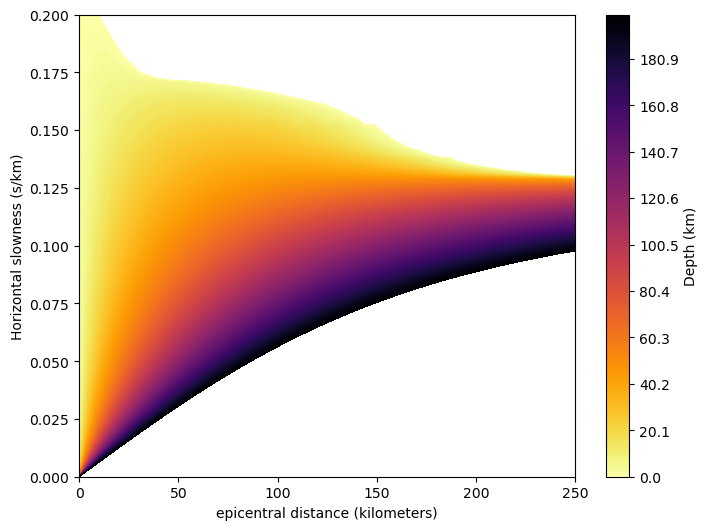

In [195]:
fig, ax = plt.subplots(figsize=(8,6))
levels = np.linspace(0, 200, 200)
sc = ax.contourf(distmat, I, depmat, levels=levels, cmap='inferno_r', vmin = 0, vmax = 200) #jet_r, 90
ax.set_xlabel('epicentral distance (kilometers)')
ax.set_ylabel('Horizontal slowness (s/km)')
ax.set_ylim(0,0.20)
fig.colorbar(sc, label = 'Depth (km)')
plt.savefig('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_depth_estimate.png', transparent=True, dpi = 600)
plt.show()

array([[  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ],
       [  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ],
       [  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ],
       ...,
       [  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ],
       [  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ],
       [  0.        ,   4.23728814,   8.47457627, ..., 241.52542373,
        245.76271186, 250.        ]])

### Slowness/baz cone

In [218]:
depth_grid_df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/dense_grid_unalaska.csv')
depth_grid_df

,Unnamed: 0,x,y,depth,baz,distance,incident_angle,2A_takeoff_angle,2A_slowness,2A_incident_angle_taup,2A_trace_velocity,2A_p_arrival
0,0,-170.000000,56.0,0.0,322.030327,331.320490,90.000000,38.080708,0.128494,38.080708,7.782469,49.821807
1,1,-169.929293,56.0,0.0,322.614772,328.465845,90.000000,38.092416,0.128527,38.092416,7.780440,49.454955
2,2,-169.858586,56.0,0.0,323.209896,325.649400,90.000000,38.095140,0.128535,38.095140,7.779968,49.092949
3,3,-169.787879,56.0,0.0,323.815830,322.872158,90.000000,38.108133,0.128572,38.108133,7.777718,48.735915
4,4,-169.717172,56.0,0.0,324.432698,320.135140,90.000000,38.126094,0.128624,38.126094,7.774611,48.383933
...,...,...,...,...,...,...,...,...,...,...,...,...
669995,669995,-163.282828,50.0,250.0,148.601196,474.887673,62.235874,109.650158,0.107523,31.071792,9.300312,67.328215
669996,669996,-163.212121,50.0,250.0,148.066739,477.339482,62.357318,109.491601,0.107629,31.105781,9.291167,67.591972
669997,669997,-163.141414,50.0,250.0,147.537497,479.828084,62.479588,109.326399,0.107739,31.140926,9.281733,67.859950
669998,669998,-163.070707,50.0,250.0,147.013463,482.352906,62.602621,109.173162,0.107839,31.173279,9.273068,68.132095


In [228]:
target_slow = 0.1
slow_tol = 0.01
target_baz = 160
baz_tol = 5

#small_df = depth_grid_df[depth_grid_df['station 2A slowness'] > target_slow+slow_tol]

small_df = depth_grid_df[
    (depth_grid_df['2A_slowness'] < target_slow+slow_tol) &
    (depth_grid_df['2A_slowness']  > target_slow-slow_tol)&
    (depth_grid_df['baz']  > target_baz-baz_tol)&
    (depth_grid_df['baz']  < target_baz+baz_tol)].reset_index(drop=True)



In [220]:
path = '/Users/cadequigley/Downloads/alu_slab2_dep_02.23.18.xyz'
slab = pd.read_csv(path, names = ['x','y','z'])
slab = slab.dropna(subset=['z'])
slab['z'] = -1*slab['z']
slab['x'] = slab['x']-360

slab = slab[
    (slab['x'] < max(depth_grid_df['x'])) &
    (slab['x']  > min(depth_grid_df['x']))&
    (slab['y']  > min(depth_grid_df['y']))&
    (slab['y']  < max(depth_grid_df['y']))].reset_index(drop=True)

slab

,x,y,z
0,-163.40,55.95,219.515625
1,-163.35,55.95,216.200577
2,-163.30,55.95,212.944138
3,-163.25,55.95,209.748886
4,-163.20,55.95,206.616913
...,...,...,...
7854,-169.80,51.35,8.284230
7855,-169.75,51.35,8.197917
7856,-169.70,51.35,8.113379
7857,-169.95,51.30,8.226417


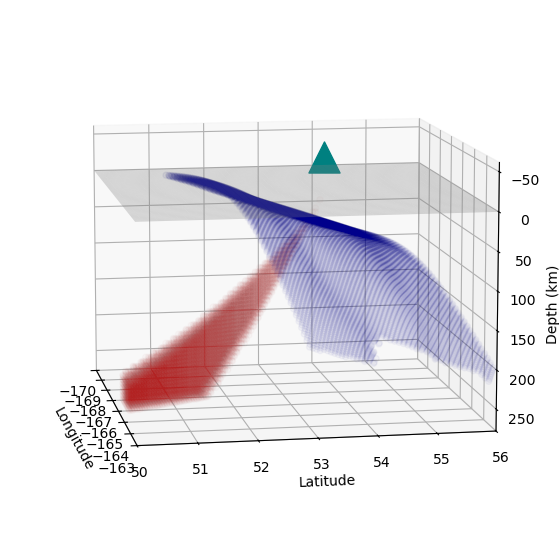

In [232]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

array_lat = 53.69619999999999 #2A
array_lon = -166.7326 #2A
array_dep = 0
df = small_df
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(slab['x'], slab['y'],slab['z'], color = 'darkblue', alpha = 0.03)

sc = ax.scatter(
    df["x"],
    df["y"],
    df["depth"],
    color = 'firebrick',
    #c=df["value"],          # color by value (optional)
    #cmap="inferno",
    #s=5,
    #edgecolor = 'black',
    alpha=0.02
)


#ax.scatter(slab['x'], slab['y'],slab['z'], color = 'gray', alpha = 0.3)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (km)")
ax.invert_zaxis()           # geophysical convention
#ax.view_init(elev=90, azim=0)     # top-down
#ax.view_init(elev=0, azim=0)      # side view
ax.view_init(elev=10, azim=350)    # common 3D perspective
ax.set_xlim(min(depth_grid_df['x']),max(depth_grid_df['x']))
ax.set_ylim(min(depth_grid_df['y']),max(depth_grid_df['y']))
#ax.set_zlim(100,0)

#ax.scatter(depth_grid_df['x'], depth_grid_df['y'], depth_grid_df['depth'], alpha = 0.01, color = 'gray')



# Create a grid covering your plot extent
x_surf = np.linspace(
    min(depth_grid_df['x']),
    max(depth_grid_df['x']),
    50
)
y_surf = np.linspace(
    min(depth_grid_df['y']),
    max(depth_grid_df['y']),
    50
)

X_surf, Y_surf = np.meshgrid(x_surf, y_surf)
Z_surf = np.zeros_like(X_surf)  # z = 0 surface

# Plot translucent surface
ax.plot_surface(
    X_surf,
    Y_surf,
    Z_surf,
    color="gray",
    alpha=0.30,        # transparency (0 = invisible, 1 = opaque)
    linewidth=0,
    shade=False
)

ax.scatter(array_lon, array_lat, array_dep-40, color = 'teal', marker = '^', s= 500)



#cbar = plt.colorbar(sc, ax=ax)
#cbar.set_label("Value")
#plt.savefig('/Users/cadequigley/Downloads/Research/paper_figures/3D_slowness_baz_cone.png', transparent=True, dpi = 700)
plt.show()


In [234]:
depth_grid_df

,Unnamed: 0,x,y,depth,baz,distance,incident_angle,2A_takeoff_angle,2A_slowness,2A_incident_angle_taup,2A_trace_velocity,2A_p_arrival
0,0,-170.000000,56.0,0.0,322.030327,331.320490,90.000000,38.080708,0.128494,38.080708,7.782469,49.821807
1,1,-169.929293,56.0,0.0,322.614772,328.465845,90.000000,38.092416,0.128527,38.092416,7.780440,49.454955
2,2,-169.858586,56.0,0.0,323.209896,325.649400,90.000000,38.095140,0.128535,38.095140,7.779968,49.092949
3,3,-169.787879,56.0,0.0,323.815830,322.872158,90.000000,38.108133,0.128572,38.108133,7.777718,48.735915
4,4,-169.717172,56.0,0.0,324.432698,320.135140,90.000000,38.126094,0.128624,38.126094,7.774611,48.383933
...,...,...,...,...,...,...,...,...,...,...,...,...
669995,669995,-163.282828,50.0,250.0,148.601196,474.887673,62.235874,109.650158,0.107523,31.071792,9.300312,67.328215
669996,669996,-163.212121,50.0,250.0,148.066739,477.339482,62.357318,109.491601,0.107629,31.105781,9.291167,67.591972
669997,669997,-163.141414,50.0,250.0,147.537497,479.828084,62.479588,109.326399,0.107739,31.140926,9.281733,67.859950
669998,669998,-163.070707,50.0,250.0,147.013463,482.352906,62.602621,109.173162,0.107839,31.173279,9.273068,68.132095


### distance/depth relation

In [125]:
array = '2A'
dip = '20'
strike = '249'
snell = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
comb = pd.merge(snell, df1, on='event_id', how='inner')



In [215]:
levels = np.linspace(0, 0.2, 10)
len(levels)

10

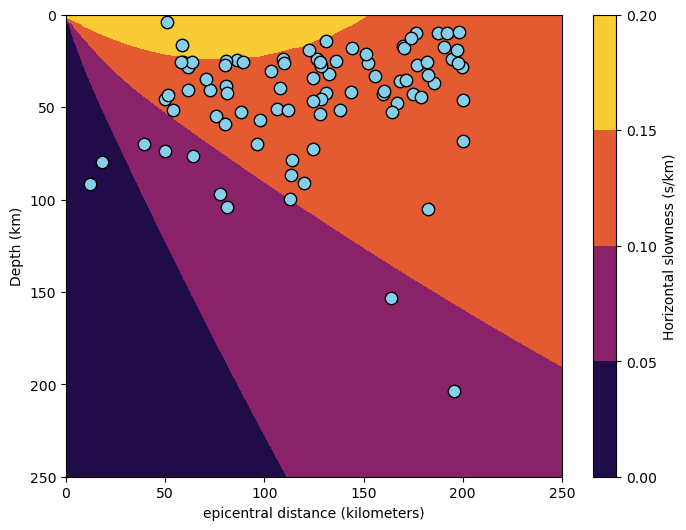

In [217]:
fig, ax = plt.subplots(figsize=(8,6))
target = 0.05
tolerance = 0.02
levels = np.linspace(0, 0.2, 5)
#levels = np.linspace(target-tolerance, target+tolerance, 2)
sc = ax.contourf(distmat, depmat, I, levels=levels, cmap='inferno', vmin = 0, vmax = 0.2) #jet_r, 90
ax.scatter(comb['2A_epicentral_distance'], comb['eq_depth(km)'], s= 80, color = 'skyblue',edgecolors = 'black')
#ax.scatter()
ax.set_xlabel('epicentral distance (kilometers)')
ax.set_ylabel('Depth (km)')
ax.set_ylim(0,250)
ax.set_xlim(0,250)

fig.colorbar(sc, label = 'Horizontal slowness (s/km)')
ax.invert_yaxis()
#plt.savefig('/Users/cadequigley/Downloads/Research/paper_figures/dep_dist_slow_relationship_w_events.png', transparent=True, dpi = 700)
plt.show()

### Distance errors testing, mostly trash

In [46]:
#Find distance errors----------------------------

num_slow = 60
slow_max = 0.2
slow_min = 0
slow_tol = 0.01 #s/km, 0.03
dist_tol = 5 #km

slow_vec = np.linspace(slow_min,slow_max,num_slow)

dist_vec = np.linspace(dist_min,dist_max,num_dist)

distmat, slowmat = np.meshgrid(dist_vec, slow_vec)

depth_error_target = np.zeros((num_slow, num_dist))
depth_error_max = np.zeros((num_slow, num_dist))


for i in range(num_slow):
    distances = distmat[i]
    slownesses = slowmat[i]
    for j in range(num_slow):
        target_dist = distances[j]
        target_slow = slownesses[j]

        # Find closest grid point
        D = (distmat - target_dist)**2 + (I - target_slow)**2
        k, q = np.unravel_index(D.argmin(), D.shape)

        # Get the depth at target point
        depth_value = depmat[k, q]

        # Build a mask for points within the tolerances
        mask = (
            (np.abs(distmat - target_dist) <= dist_tol) &
            (np.abs(I - target_slow) <= slow_tol)
        )

# Extract depths at those grid points
        depths_in_window = depmat[mask]

        if len(depths_in_window) > 0:
            depth_error_target[i,j] = max(abs(depth_value - depths_in_window))
            depth_error_max[i,j] = max(depths_in_window) - min(depths_in_window)

        else:
            depth_error_target[i,j] = 1000
            depth_error_max[i,j] = 1000
            

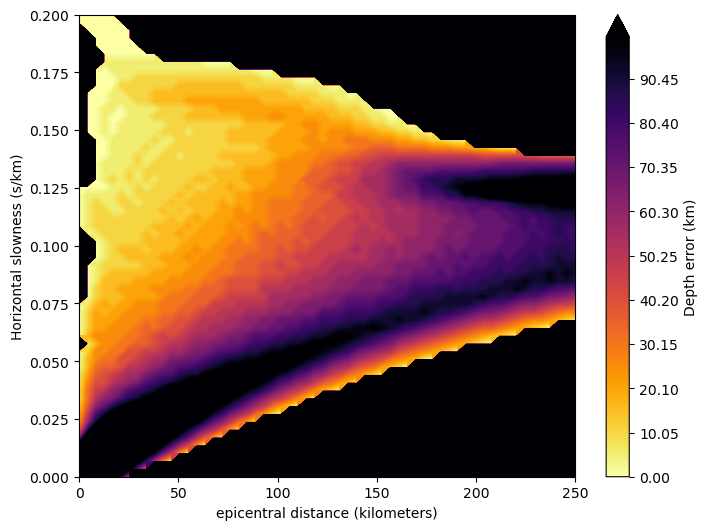

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
levels = np.linspace(0, 100, 200)
sc = ax.contourf(distmat, slowmat, depth_error_max, levels=levels, cmap='inferno_r', vmin = 0, vmax = 100, extend = 'max') #jet_r, 90
ax.set_xlabel('epicentral distance (kilometers)')
ax.set_ylabel('Horizontal slowness (s/km)')
ax.set_ylim(0,0.20)
fig.colorbar(sc, label = 'Depth error (km)')
#plt.savefig('/Users/cadequigley/Downloads/depth_estimate_ess.png', transparent=True)
plt.show()

In [72]:
#Find distance errors----------------------------

num_slow = 60
slow_max = 0.2
slow_min = 0
depth_tol = 10 #km
dist_tol = 10 #km

depth_vec = np.linspace(depth_min,depth_max,num_slow)

dist_vec = np.linspace(dist_min,dist_max,num_dist)

distmat, depthmat = np.meshgrid(dist_vec, depth_vec)

slow_error_target = np.zeros((num_slow, num_dist))
slow_error_max = np.zeros((num_slow, num_dist))
slow_error_temp = np.zeros((num_slow,num_dist))


for i in range(num_slow):
    distances = distmat[i]
    depths = depthmat[i]
    for j in range(num_slow):
        target_dist = distances[j]
        target_depth = depths[j]

        # Find closest grid point
        D = (distmat - target_dist)**2 + (depthmat - target_depth)**2
        k, q = np.unravel_index(D.argmin(), D.shape)

        # Get the depth at target point
        slow_value = I[k, q]

        # Build a mask for points within the tolerances
        mask = (
            (np.abs(distmat - target_dist) <= dist_tol) &
            (np.abs(depmat - target_depth) <= slow_tol)
        )

# Extract slownesses at those grid points
        slow_in_window = I[mask]

        if len(slow_in_window) > 0: #ensures that there are points
            slow_error_target[i,j] = max(abs(slow_value - slow_in_window)) #difference between target and max difference
            slow_error_max[i,j] = max(slow_in_window) - min(slow_in_window) #max difference in slowness in window
            
            if max(slow_in_window) - min(slow_in_window) > 0.03: #condition that point is non unique (exceeds threshold of slowness resolution)
                slow_error_temp[i,j] = -1
            else:
                slow_error_temp[i,j] = 1

        else:
            slow_error_target[i,j] = 1000
            slow_error_max[i,j] = 1000
            

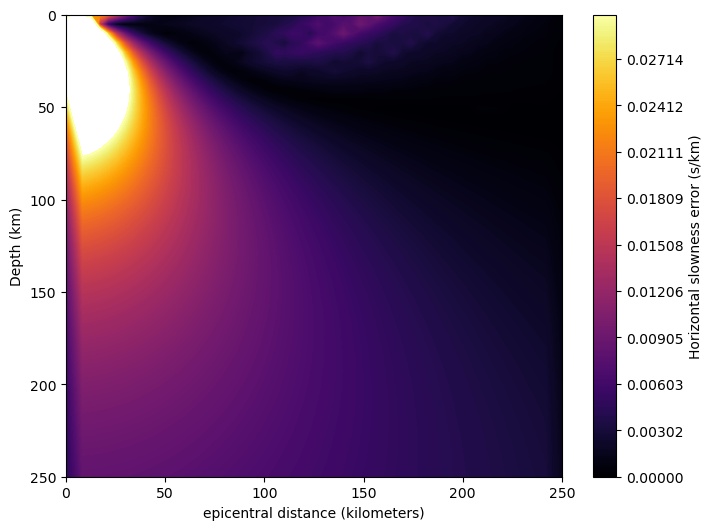

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
levels = np.linspace(0, 0.03, 200)
sc = ax.contourf(distmat, depmat, slow_error_max, levels=levels, cmap='inferno') #jet_r, 90
ax.set_xlabel('epicentral distance (kilometers)')
ax.set_ylabel('Depth (km)')
ax.set_ylim(0,250)

fig.colorbar(sc, label = 'Horizontal slowness error (s/km)')
ax.invert_yaxis()
#plt.savefig('/Users/cadequigley/Downloads/Research/paper_figures/dep_dist_slow_relationship.png', transparent=True, dpi = 700)
plt.show()

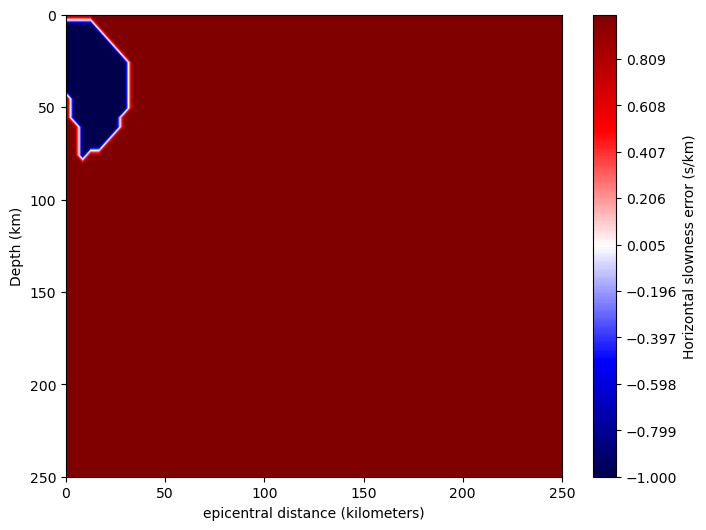

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
levels = np.linspace(-1, 1, 200)
sc = ax.contourf(distmat, depmat, slow_error_temp, levels=levels, cmap='seismic') #jet_r, 90
ax.set_xlabel('epicentral distance (kilometers)')
ax.set_ylabel('Depth (km)')
ax.set_ylim(0,250)

fig.colorbar(sc, label = 'Horizontal slowness error (s/km)')
ax.invert_yaxis()
#plt.savefig('/Users/cadequigley/Downloads/Research/paper_figures/dep_dist_slow_relationship.png', transparent=True, dpi = 700)
plt.show()

In [23]:
slow_space = np.linspace(0, 0.2, 60)
len(dist_vec)

60

In [26]:
len(I[0])

60

In [28]:
target_slow

0.16666666666666666

### Indexing matrices to get points

In [29]:
trace_vel = 6
target_dist = 50.0          # km
target_slow = 1 / trace_vel  # s/km

dist_tol = 10.0              # km
slow_tol = 0.03              # s/km

# Build a mask for points within the tolerances
mask = (
    (np.abs(distmat - target_dist) <= dist_tol) &
    (np.abs(I - target_slow) <= slow_tol)
)

# Extract depths at those grid points
depths_in_window = depmat[mask]

print("Number of matching grid points:", depths_in_window.size)
print("Depths:", depths_in_window)


Number of matching grid points: 31
Depths: [ 0.          0.          0.          0.          0.          5.08474576
  5.08474576  5.08474576  5.08474576  5.08474576 10.16949153 10.16949153
 10.16949153 10.16949153 10.16949153 15.25423729 15.25423729 15.25423729
 15.25423729 15.25423729 20.33898305 20.33898305 20.33898305 20.33898305
 20.33898305 25.42372881 25.42372881 25.42372881 25.42372881 25.42372881
 30.50847458]


In [18]:
trace_vel = 6
target_dist = 230.0   # km
target_slow = 1/trace_vel    # s/km
print('Target slowness: ', target_slow)
# Find closest grid point
D = (distmat - target_dist)**2 + (I - target_slow)**2
j, i = np.unravel_index(D.argmin(), D.shape)

# Get the depth
depth_value = depmat[j, i]

print("Closest depth:", depth_value)


Target slowness:  0.16666666666666666
Closest depth: 0.0


In [87]:
import pygmt
import pandas as pd
import numpy as np

#INPUTS--------------

max_freq = 10 #Hz
window_length = 1 #SECONDS
array = '2A' #'POM', '3A', "2A"
array1 = '2A' #'pom', '3a'
analysis = 'fk' #fk, lts
timing = 'quarter' #quarter, half, start

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'
#PULLING DATA
if analysis == 'lts':
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
else:
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
    else:
        df1 = pd.read_csv(analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
###############################################################
df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])

df = pd.read_csv('~/Downloads/Research/2014-15_eqs.txt', delimiter = '|')
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
#df2 = pd.read_csv("/Users/cadequigley/Downloads/Research/ls_time_plots/spatial_example_baz_errors.csv")
comb = pd.merge(dfbaz, df1, on='event_id', how='inner')


In [88]:
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometers2degrees

from obspy.taup import TauPyModel
from obspy.taup import taup_create
mod = 'japan_1d' #pavdut, iasp91, japan_1d, ak135
#model = TauPyModel(model="pavdut")
model = TauPyModel(model=mod)

lat_2a = 53.69619999999999
lon_2a = -166.7326
lat_3a = 53.77933636363636
lon_3a = -166.21232727272726
lat_pom = 53.85690833333333
lon_pom = -166.41502499999999

array_lats = [lat_2a, lat_3a, lat_pom]
array_lons = [lon_2a, lon_3a, lon_pom]
station_names = ['2A', '3A', 'POM']

#df = pd.read_csv('/Users/cadequigley/Downloads/completed_runs_v2/record_sections_picks/POM_epic_times.csv')
#df = df.rename(columns={'eq_name': 'event_id'})
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
df1 = comb
eq_lats = df1['eq_latitude'].to_numpy()
eq_lons = df1['eq_longitude'].to_numpy()
eq_depths = df1['eq_depth(km)'].to_numpy()
event_ids = df1['event_id'].to_numpy()

slowness_list = []
incident_list = []
trace_vel_list = []
takeoff_list = []
takeoff_from_depth_list = []

for i in range(len(station_names)):
    array = station_names[i]
    arr_lat = array_lats[i]
    arr_lon = array_lons[i]
    slowness = []
    incident = []
    trace_vel = []
    takeoffs = []
    takeoff_from_depth = []
    for j in range(len(eq_lats)):
        eq_lat = eq_lats[j]
        eq_lon = eq_lons[j]
        depth = eq_depths[j]
        distance,baz,az = gps2dist_azimuth(arr_lat,arr_lon,eq_lat,eq_lon)
        distance = distance/1000

        dist_deg = kilometers2degrees(distance)

        #use 1d model to get incident angle/slowness
        arrivals_p = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=dist_deg,
                                  phase_list = ["P","p"])

        arr = arrivals_p[0]
        ptime = arr.time
        angle = arr.incident_angle
        takeoff = arr.takeoff_angle
        takeoffs.append(takeoff)
        if mod == 'iasp91':
            vh = 5.8/(np.sin(np.deg2rad(angle))) #iasp91 surface velocity: 5.8
        elif mod == 'japan_1d':
            vh = 4.8/(np.sin(np.deg2rad(angle))) #japan_1D surface velocity: 5.8
        elif mod == 'ak135':
            vh = 5.8/(np.sin(np.deg2rad(angle)))
        else:
            vh = 3.05/(np.sin(np.deg2rad(angle))) #pavdut surface velocity: 3.05
        slow = 1/vh
        slowness.append(slow)
        incident.append(angle)
        trace_vel.append(vh)
        takeoff_from_depth.append(np.rad2deg(np.arctan(distance/depth)))

    slowness_list.append(slowness)
    incident_list.append(incident)
    trace_vel_list.append(trace_vel)
    takeoff_list.append(takeoffs)
    takeoff_from_depth_list.append(takeoff_from_depth)


baz_2a = []
dist_2a = []
baz_3a = []
dist_3a = []
baz_pom = []
dist_pom = []

for i in range(len(eq_lats)):
    lat = eq_lats[i]
    lon = eq_lons[i]
    #2A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_2a,lon_2a)
    baz_2a.append(az)
    dist_2a.append(dist/1000)
    #3A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_3a,lon_3a)
    baz_3a.append(az)
    dist_3a.append(dist/1000)
    #POM-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_pom,lon_pom)
    baz_pom.append(az)
    dist_pom.append(dist/1000)

baz_2a = np.array(baz_2a)
baz_3a = np.array(baz_3a)
baz_pom = np.array(baz_pom)

#df = pd.DataFrame(slowness_list[0], columns)
df = pd.DataFrame({
        '2A_'+mod+'_slowness': slowness_list[0],
        '3A_'+mod+'_slowness': slowness_list[1],
        'POM_'+mod+'_slowness': slowness_list[2],
        '2A_'+mod+'_incidence': incident_list[0],
        '3A_'+mod+'_incidence': incident_list[1],
        'POM_'+mod+'_incidence': incident_list[2],
        '2A_'+mod+'_trace_vel': trace_vel_list[0],
        '3A_'+mod+'_trace_vel': trace_vel_list[1],
        'POM_'+mod+'_trace_vel': trace_vel_list[2],
        '2A_'+mod+'_takeoff': takeoff_list[0],
        '3A_'+mod+'_takeoff': takeoff_list[1],
        'POM_'+mod+'_takeoff': takeoff_list[2],
        '2A_depth_takeoff': takeoff_from_depth_list[0],
        '3A_depth_takeoff': takeoff_from_depth_list[1],
        'POM_depth_takeoff': takeoff_from_depth_list[2],
        '2A_baz': baz_2a,
        '3A_baz': baz_3a,
        'POM_baz': baz_pom,
        '2A_dist': dist_2a,
        '3A_dist': dist_3a,
        'POM_dist': dist_pom,
        'event_id': event_ids
        
    })

        

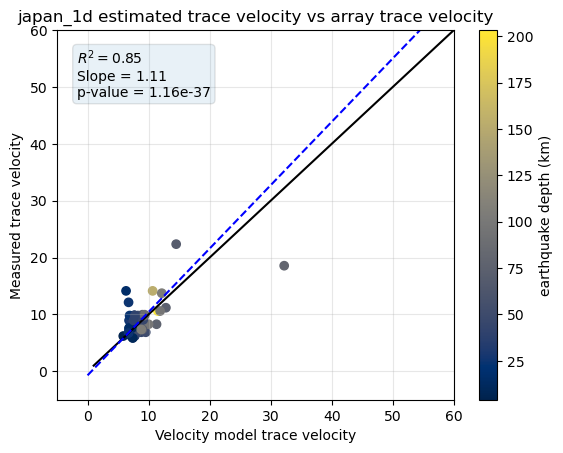

In [89]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
array = '2A'

fig,ax = plt.subplots()

x = df[array+'_'+mod+'_trace_vel']
if analysis == 'lts':
    y = comb['trace_vel']
else:
    y = 1/comb['slow']

sc = ax.scatter(x, y, c = comb['eq_depth(km)'], cmap = 'cividis')
ax.plot(np.linspace(1, 250, 200), np.linspace(1, 250, 200), color = 'black')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
plt.colorbar(sc, label = 'earthquake depth (km)')
ax.set_xlabel('Velocity model trace velocity')
ax.set_ylabel('Measured trace velocity')
ax.set_title(mod+' estimated trace velocity vs array trace velocity')
ax.set_xlim(-5,60)
ax.set_ylim(-5,60)
ax.grid(alpha = 0.3)
plt.show()


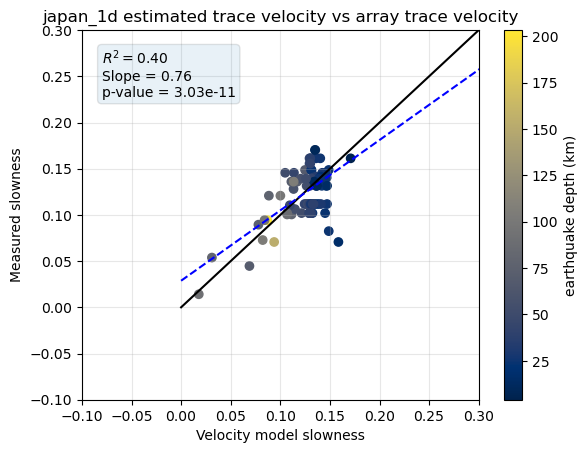

In [90]:
from scipy.stats import linregress
array = '2A'

fig,ax = plt.subplots()

#x = df[array+'_'+mod+'_slowness']
x = new[array+'_japan_1d_slowness'].to_numpy()
#

if analysis == 'lts':
   y = 1/comb['trace_vel']
else:
    y = comb['slow']

sc = ax.scatter(x, y, c = comb['eq_depth(km)'], cmap = 'cividis')
ax.plot(np.linspace(0, 250, 200), np.linspace(0, 250, 200), color = 'black')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
plt.colorbar(sc, label = 'earthquake depth (km)')
ax.set_xlabel('Velocity model slowness')
ax.set_ylabel('Measured slowness')
ax.set_title(mod+' estimated trace velocity vs array trace velocity')
ax.set_xlim(-0.1,0.3)
ax.set_ylim(-0.1,0.3)
ax.grid(alpha = 0.3)
plt.show()


In [55]:
r_value**2

0.5370424848880603

In [ ]:
pd.set_option('display.max_columns', None)

### STATISTICS

In [1]:
def quantile_range(array): #numpy array
    ah = np.quantile(array, 0.95)
    aw = np.quantile(array, 0.05)
    return ah-aw

In [2]:
### Niazi model (see fig3....ipynb)-------------------------
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)
#params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)
a_fit = -0.09120995741014604
b_fit = 25.25657943756652
phi_fit = 71.25675480152088

params = a_fit, b_fit, phi_fit

Z_fit = baz_real
niazi = cos_model(Z_fit, *params)

NameError: name 'baz_real' is not defined

In [3]:
### STATISTICS FOR COMPARING WINDOW/FREQ/SLOWNESS

#import pygmt
import pandas as pd
import numpy as np
from scipy.stats import linregress
pd.set_option('display.max_columns', None)

#Pull deflection data-----------------------------------
strike = '249'
dip = '20'
array = '2A'
test = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')
test = test.sort_index(ascending=False)

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '2A' #'POM', '3A', "2A"
array1 = '2a' #'pom', '3a', '2a'
analysis = 'fk' #fk, lts
timing = 'quarter' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]


##Set up comparison data------------------------------------------
baz_error_model = test[array+'_baz_error_model'].to_numpy() #3D snell baz deflection
slowness_error_model = test[array+'_slowness_error'].to_numpy() #3D snell slowness deflection
slowness_model = test[array+'_japan_1d_slowness'].to_numpy() #slowness from 1D japan model
baz_real = test[array+'_baz'] #USGS catalog baz

### Niazi model (see fig3....ipynb)-------------------------
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)
#params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)
a_fit = -0.09120995741014604
b_fit = 25.25657943756652
phi_fit = 71.25675480152088

params = a_fit, b_fit, phi_fit

Z_fit = baz_real
niazi = cos_model(Z_fit, *params)

### Start looping through window/freq combinations-------------------------------------

dfs = []
for i in range(len(window_length_list)):
    
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        new = pd.merge(comb,test, on = 'event_id', how = 'inner')
       # new = new.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
        

##########SET UP DATA#############################################
        baz_error_array = new['baz_error'].to_numpy()
        if analysis == 'fk':
            baz_array = new['corrected_baz'].to_numpy()
            slowness_array = new['slow'].to_numpy()
        else:
            baz_array = new['baz'].to_numpy()
            #slowness_array = 1/comb['trace_vel'].to_numpy()
            slowness_array = 1/new['trace_vel'].to_numpy() #everything mislabeled but testing

##Set up comparison data------------------------------------------
        baz_error_model = new[array+'_baz_error_model'].to_numpy() #3D snell baz deflection
        slowness_error_model = new[array+'_slowness_error'].to_numpy() #3D snell slowness deflection
        slowness_model = new[array+'_japan_1d_slowness'].to_numpy() #slowness from 1D japan model
        baz_real = new[array+'_baz'] #USGS catalog baz

        Z_fit = baz_real
        niazi = cos_model(Z_fit, *params)
##########STATISTICS#############################################
    ###Slowness
        ### Slowness 
        slow_slope, slow_intercept, slow_r_value, slow_p_value, std_err = linregress(slowness_array, slowness_model)
        ### Slowness error
        slow_error_array = slowness_model - slowness_array
        range_slow_error = quantile_range(slow_error_array) #quantile range slowness error
        std_slow_error = np.std(slow_error_array) #standard deviation
        ### Modeled slowness error vs. observed
        slow_error_slope, slow_error_intercept, slow_error_r_value, slow_error_p_value, std_err = linregress(slow_error_array, slowness_error_model)
        ### Removing modeled slowness error
        range_slow_error_mod_removed = quantile_range(slow_error_array - slowness_error_model) #quantile range slowness error
        std_slow_error_mod_removed = np.std(slow_error_array - slowness_error_model) #standard deviation
        ### Trend-corrected slowness
        range_slow_error_trend_removed = quantile_range(slowness_model - (slow_slope*slowness_array +slow_intercept)) #quantile range slowness error
        std_slow_error_trend_removed = np.std(slowness_model - (slow_slope*slowness_array +slow_intercept)) #standard deviation
    ###Backazimuth
        ### Backazimuth error (unadjusted)
        range_baz_error = quantile_range(baz_error_array) #quantile range baz error
        std_baz_error = np.std(baz_error_array) #standard deviation
        ### Backazimuth
        baz_slope, baz_intercept, baz_r_value, baz_p_value, std_err = linregress(baz_array, baz_real)
        ### Compare baz error
        baz_error_slope, baz_error_intercept, baz_error_r_value, baz_error_p_value, std_err = linregress(baz_error_array, baz_error_model)
        ### Baz error with modeled removed
        range_baz_error_model_removed = quantile_range(baz_error_array - baz_error_model)
        std_baz_error_model_removed = np.std(baz_error_array - baz_error_model)
        range_baz_error_model_removed_niazi = quantile_range(baz_error_array - niazi)#FIX THIS
        std_baz_error_model_removed_niazi = np.std(baz_error_array - niazi)#FIX THIS
        


##########SAVE DATA#############################################
        
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length,
                'slowness_slope': slow_slope,
                'slowness_intercept': slow_intercept,
                'slowness_rvalue': slow_r_value,
                'slowness_pvalue': slow_p_value,
                'slowness_error_quantile_range': range_slow_error,
                'slowness_error_std': std_slow_error,
                'slowness_error_slope': slow_error_slope,
                'slowness_error_intercept': slow_error_intercept,
                'slowness_error_rvalue': slow_error_r_value,
                'slowness_error_pvalue': slow_error_p_value,
                'slowness_error_quantile_range_mod_removed': range_slow_error_mod_removed,
                'slowness_error_std_mod_removed': std_slow_error_mod_removed,
                'slowness_error_quantile_range_trend_removed': range_slow_error_trend_removed,
                'slowness_error_std_trend_removed': std_slow_error_trend_removed,
                ###BAZ
                'baz_error_quantile_range': range_baz_error,
                'baz_error_std': std_baz_error,
                'baz_slope': baz_slope,
                'baz_intercept': baz_intercept,
                'baz_rvalue': baz_r_value,
                'baz_error_slope': baz_error_slope,
                'baz_error_intercept': baz_error_intercept,
                'baz_error_rvalue': baz_error_r_value,
                'baz_error_pvalue': baz_error_p_value,
                'baz_error_quantile_range_mod_removed': range_baz_error_model_removed,
                'baz_error_std_mod_removed': std_baz_error_model_removed,
                'baz_error_quantile_range_niazi_removed': range_baz_error_model_removed_niazi,
                'baz_error_std_niazi_removed': std_baz_error_model_removed_niazi,
                'number_events_real': len(new),
                'analysis_type': analysis,
                'start_time': timing,
            
        
                }, index=[0])

        dfs.append(df)



df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
#df6



In [4]:
df6

,max_freq,window_length,slowness_slope,slowness_intercept,slowness_rvalue,slowness_pvalue,slowness_error_quantile_range,slowness_error_std,slowness_error_slope,slowness_error_intercept,slowness_error_rvalue,slowness_error_pvalue,slowness_error_quantile_range_mod_removed,slowness_error_std_mod_removed,slowness_error_quantile_range_trend_removed,slowness_error_std_trend_removed,baz_error_quantile_range,baz_error_std,baz_slope,baz_intercept,baz_rvalue,baz_error_slope,baz_error_intercept,baz_error_rvalue,baz_error_pvalue,baz_error_quantile_range_mod_removed,baz_error_std_mod_removed,baz_error_quantile_range_niazi_removed,baz_error_std_niazi_removed,number_events_real,analysis_type,start_time
0,20,4.0,0.378406,0.078909,0.477785,2.509907e-06,0.077250,0.027575,0.691969,-0.035140,0.284683,0.007183,0.211467,0.064811,0.063284,0.020564,66.905863,19.635630,1.236818,-41.400938,0.968552,0.816984,2.879453,0.759168,1.026736e-17,41.228042,14.215785,47.475511,15.172336,88,fk,quarter
1,14,4.0,0.418613,0.072692,0.514864,2.865388e-07,0.076085,0.026132,0.730099,-0.033014,0.284649,0.007190,0.211822,0.064639,0.063462,0.020067,67.258936,20.717870,1.209371,-36.098367,0.959364,0.732862,2.032552,0.718533,3.233262e-15,40.608359,15.704054,47.640479,17.008392,88,fk,quarter
2,10,4.0,0.426973,0.073542,0.509356,4.020637e-07,0.078066,0.025726,0.749081,-0.036343,0.287517,0.006604,0.200733,0.064519,0.064213,0.020144,67.258936,20.175433,1.176005,-31.468182,0.958601,0.709037,2.379153,0.676973,4.457342e-13,45.129005,16.623576,50.745489,17.992684,88,fk,quarter
3,8,4.0,0.487546,0.067010,0.574440,4.857339e-09,0.071973,0.023810,0.739700,-0.037564,0.262764,0.013386,0.201376,0.064967,0.057406,0.019161,52.672057,19.849216,1.108793,-20.505922,0.954127,0.615089,1.944359,0.577778,3.771769e-09,47.203102,18.863500,51.484604,20.213240,88,fk,quarter
4,6,4.0,0.502057,0.062474,0.658298,3.170231e-12,0.063499,0.023325,0.580681,-0.033437,0.202080,0.059012,0.202905,0.066368,0.047344,0.017621,57.846196,18.862745,1.088161,-16.379718,0.957681,0.604543,1.448848,0.539649,5.780772e-08,52.222076,19.290582,52.310608,20.730636,88,fk,quarter
5,20,3.0,0.394895,0.075577,0.507703,4.445621e-07,0.074983,0.027172,0.697334,-0.032849,0.282701,0.007614,0.214906,0.064816,0.063357,0.020167,68.273411,20.364476,1.239421,-41.539076,0.964969,0.774984,2.558060,0.746871,6.565564e-17,43.864772,14.779768,46.325657,15.526157,88,fk,quarter
6,14,3.0,0.425244,0.071269,0.539178,5.966655e-08,0.076085,0.026070,0.773251,-0.031921,0.300762,0.004409,0.214906,0.064195,0.062241,0.019714,68.626484,20.936343,1.175270,-30.733167,0.954346,0.669343,1.895147,0.663177,1.924625e-12,45.685635,17.264500,48.359858,18.280472,88,fk,quarter
7,10,3.0,0.432934,0.071834,0.531444,9.961080e-08,0.080065,0.025665,0.699304,-0.034559,0.267773,0.011660,0.207118,0.065038,0.063115,0.019829,67.822944,21.015374,1.158975,-29.019360,0.952236,0.647143,2.325382,0.643601,1.350819e-11,45.129005,17.791849,51.294603,18.959488,88,fk,quarter
8,8,3.0,0.515799,0.062001,0.593588,1.094026e-09,0.075661,0.022913,0.570754,-0.034819,0.195116,0.068495,0.213564,0.066469,0.058277,0.018838,54.747107,19.684057,1.108664,-21.724847,0.954980,0.617232,2.641155,0.574967,4.668199e-09,51.725507,18.859313,48.372160,20.075737,88,fk,quarter
9,6,3.0,0.554499,0.054362,0.701523,2.689250e-14,0.060292,0.021269,0.552208,-0.031906,0.175226,0.102485,0.210976,0.066672,0.050077,0.016682,57.846196,20.302020,1.059193,-12.544747,0.948612,0.492923,1.541150,0.473585,3.159419e-06,52.708749,21.268613,54.422148,22.369622,88,fk,quarter


In [84]:
new.columns

Index(['Unnamed: 0_x', 'time', 'relpow', 'abspow', 'baz_obspy', 'slow',
       'baz_error', 'new_time', 'corrected_baz', 'window_length', 'event_id',
       'freq_min', 'freq_max', 'elapsed_time', 'Unnamed: 0_y', 'eq_depth(km)',
       'eq_magnitude', 'eq_latitude', 'eq_longitude', 'eq_origin_time',
       'hypo_distance_2A(km)', 'epi_distance_2A(km)', 'hypo_distance_3A(km)',
       'epi_distance_3A(km)', 'hypo_distance_POM(km)', 'epi_distance_POM(km)',
       '2A02', '3A05', 'POM11', 'array_2A_ppicks', 'array_3A_ppicks',
       'array_POM_ppicks', 'fwd_azimuth_2a', 'fwd_azimuth_3a',
       'fwd_azimuth_pom', 'Unnamed: 0', '2A_baz', '2A_baz_error_model',
       '2A_epicentral_distance', '2A_deflection_incident', '2A_slowness_error',
       '2A_japan_1d_slowness', '2A_japan_1d_incidence',
       '2A_japan_1d_trace_vel'],
      dtype='object')

### DEPTH ESTIMATE FROM SLOW/EPICENTRAL DISTANCE ESTIMATES

In [73]:
slowness = 1/trace_vels
#Correction:
slope = 0.631589
inter = 0.050914
slowness_corrected = slowness*slope +inter
slowness_corrected

array([0.11647109, 0.1078338 , 0.13881696, 0.13009838, 0.12582841,
       0.13722422, 0.13821445, 0.14385874, 0.11414547, 0.14049872,
       0.11391569, 0.14049967, 0.10295951, 0.1425136 , 0.11425005,
       0.12249503, 0.1338541 , 0.12206954, 0.1246849 , 0.15389331,
       0.13966142, 0.13776701, 0.11940811, 0.14065675, 0.12190548,
       0.0891723 , 0.12482579, 0.12274792, 0.13501922, 0.13965449,
       0.13316802, 0.12059725, 0.11527305, 0.1331668 , 0.13009548,
       0.13729924, 0.12436294, 0.13950682, 0.10144574, 0.11230462,
       0.14022365, 0.14022365, 0.11469418, 0.07677071, 0.13250579,
       0.12752408, 0.14631675, 0.10343711, 0.13779316, 0.12389521,
       0.14015341, 0.12653124, 0.12756598, 0.11546203, 0.10825086,
       0.13616779, 0.13439057, 0.13590669, 0.0917165 , 0.11677604,
       0.14338159, 0.12574956, 0.14519974, 0.12685512, 0.13421162,
       0.06940752, 0.09133956, 0.14573832, 0.13974392, 0.13194947,
       0.13497271, 0.13416861, 0.138292  , 0.13763612, 0.12933

In [198]:
df1.columns

Index(['Unnamed: 0', 'event_id', 'eq_depth(km)', 'eq_magnitude', 'eq_latitude',
       'eq_longitude', 'eq_origin_time', 'hypo_distance_2A(km)',
       'epi_distance_2A(km)', 'hypo_distance_3A(km)', 'epi_distance_3A(km)',
       'hypo_distance_POM(km)', 'epi_distance_POM(km)', '2A02', '3A05',
       'POM11', 'array_2A_ppicks', 'array_3A_ppicks', 'array_POM_ppicks',
       'fwd_azimuth_2a', 'fwd_azimuth_3a', 'fwd_azimuth_pom'],
      dtype='object')

In [205]:
wawa = pd.read_csv('./2A_correction_depth_test.csv')
wawa

,Unnamed: 0,2A_baz,corrected_slowness,japan_slowness,slowness_error,eq_depth,epicentral_distance,event_id
0,0,106.386786,0.118633,0.127941,0.021639,52.50,164.382013,us10002ngf
1,1,74.977600,0.115489,0.111360,0.010861,78.76,113.765113,us10002ni2
2,2,197.174429,0.132322,0.136747,-0.003610,12.50,173.761419,us20002xhb
3,3,117.668401,0.122261,0.138339,0.026536,21.37,151.174541,us20002yyw
4,4,91.081064,0.125939,0.126352,0.014549,51.40,112.070059,us200030yw
...,...,...,...,...,...,...,...,...
83,83,242.621005,0.107038,0.111148,-0.009682,70.07,96.246113,us10004w6a
84,84,265.368574,0.008880,0.017821,-0.004540,91.67,12.076688,us10004wkx
85,85,111.838121,0.123282,0.132751,0.020948,38.80,80.484126,us10004wkr
86,86,108.782014,0.123773,0.129134,0.017331,40.50,72.827051,us10004wwg


In [208]:
#### Finding depth estimate-----------------------------
analysis = 'fk'
array = '2A' #POM, 2A, 3A
#distance = df[array+'_dist']
#eq_depths = df1['eq_depth(km)'].to_numpy()
#event_ids = df1['event_id'].to_numpy()
distance = wawa['epicentral_distance']
eq_depths = wawa['eq_depth']
event_ids = wawa['event_id']

#if analysis == 'lts':
    #trace_vels = df1['trace_vel'].to_numpy()
    #slowness = 1/trace_vels
#else:
    #slowness = df1['slow']
slowness = wawa['corrected_slowness']
#Correction:
slope = 0.529726 # FK, 0.631589 #slope 1 s, 10 Hz lts
inter = 0.059595
slowness_corrected = slowness*slope +inter
slow_correct = False #True, False

estimated_depth = []
depth_error = []
estimated_depth_homog = []
for i in range(len(slowness)):
    print(event_ids[i])
    #trace_vel = trace_vels[i]
    target_dist = distance[i]   # km
    if slow_correct == True:
        target_slow = slowness_corrected[i]    # s/km
    else:
        target_slow = slowness[i]
    
    print('Target slowness: ', target_slow)
    
    # Find closest grid point
    D = (distmat - target_dist)**2 + (I - target_slow)**2
    j, i = np.unravel_index(D.argmin(), D.shape)

    # Get the depth
    depth_value = depmat[j, i]
    estimated_depth.append(depth_value)
    print("Closest depth:", depth_value)
    
    ### Find depth error-----------------
    error = eq_depths[i] - depth_value
    depth_error.append(error)
    print('Depth error: ', error)


    ### Estimated depth homogenous halfspace
    ref_vel = 4.8 #iaps91: 5.8, pavdut: 3.05, japan_1d: 4.8
    depth_simp = target_dist/(np.tan(np.arcsin(ref_vel/trace_vel)))
    estimated_depth_homog.append(depth_simp)

dep_df = pd.DataFrame({'depth_error': np.array(depth_error),
          'earthquake_depth': eq_depths,
          'estimated_depth': np.array(estimated_depth),
          'event_id': event_ids,
           'distance': distance,
          'estimated_depth_homog': estimated_depth_homog
          })
    

us10002ngf
Target slowness:  0.1186331485387818
Closest depth: 81.35593220338983
Depth error:  -4.705932203389821
us10002ni2
Target slowness:  0.1154889558743063
Closest depth: 71.1864406779661
Depth error:  -28.8064406779661
us20002xhb
Target slowness:  0.1323220358080618
Closest depth: 30.508474576271183
Depth error:  -13.008474576271183
us20002yyw
Target slowness:  0.1222608530419321
Closest depth: 71.1864406779661
Depth error:  -45.4864406779661
us200030yw
Target slowness:  0.1259385214165355
Closest depth: 50.847457627118644
Depth error:  0.552542372881355
us100030xe
Target slowness:  0.1505569454299401
Closest depth: 0.0
Depth error:  46.1
us100031wv
Target slowness:  0.1420794265920416
Closest depth: 30.508474576271183
Depth error:  -4.938474576271183
us100031rp
Target slowness:  0.1649194477087716
Closest depth: 10.169491525423728
Depth error:  9.14050847457627
us100033l2
Target slowness:  0.1237697549084497
Closest depth: 40.67796610169491
Depth error:  -15.107966101694913
us1

In [209]:
dep_df

,depth_error,earthquake_depth,estimated_depth,event_id,distance,estimated_depth_homog
0,-4.705932,52.50,81.355932,us10002ngf,164.382013,123.286510
1,-28.806441,78.76,71.186441,us10002ni2,113.765113,85.323834
2,-13.008475,12.50,30.508475,us20002xhb,173.761419,130.321064
3,-45.486441,21.37,71.186441,us20002yyw,151.174541,113.380906
4,0.552542,51.40,50.847458,us200030yw,112.070059,84.052544
...,...,...,...,...,...,...
83,-49.071186,70.07,76.271186,us10004w6a,96.246113,72.184585
84,-161.680847,91.67,183.050847,us10004wkx,12.076688,9.057516
85,-41.762712,38.80,45.762712,us10004wkr,80.484126,60.363095
86,-9.692712,40.50,45.762712,us10004wwg,72.827051,54.620289


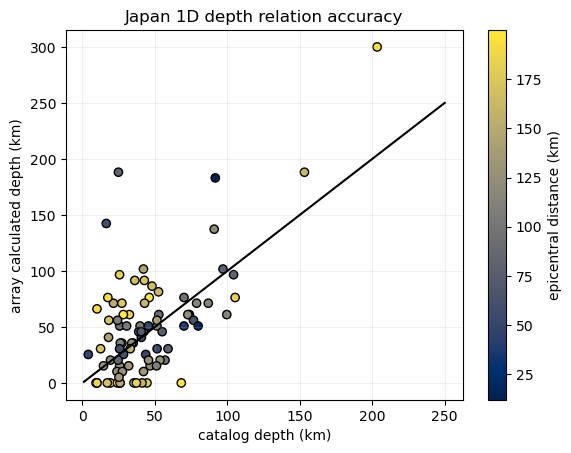

In [212]:
fig,ax = plt.subplots()

sc = ax.scatter(dep_df['earthquake_depth'], dep_df['estimated_depth'], c=dep_df['distance'], cmap = 'cividis',  edgecolors = 'black')
#sc = ax.scatter(dep_df['earthquake_depth'], dep_df['estimated_depth_homog'], c=dep_df['distance'], cmap = 'cividis',  edgecolors = 'black')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.plot(np.linspace(1, 250, 200), np.linspace(1, 250, 200), color = 'black')

ax.grid(alpha = 0.2)
ax.set_xlabel('catalog depth (km)')
ax.set_ylabel('array calculated depth (km)')
ax.set_title('Japan 1D depth relation accuracy')

plt.show()

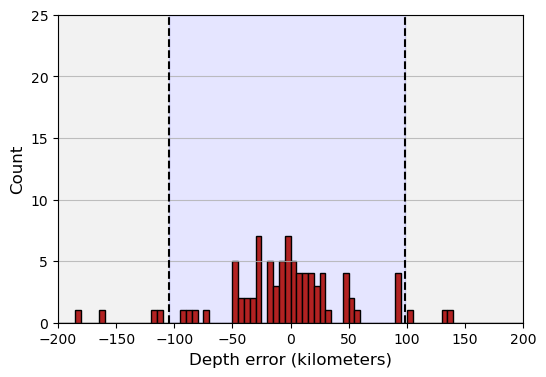

203.22334745762697


In [213]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
corrected = dep_df['depth_error'].to_numpy()
#corrected =  dep_df['earthquake_depth'].to_numpy()-dep_df['estimated_depth_homog'].to_numpy()

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('Depth error (kilometers)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-200,200)
ax.set_ylim(0, 25)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('ls_histogram_timing_ssa.png', transparent=True, dpi = 720)
plt.show()
print(range1)

### Big array

In [128]:
import pandas as pd
#df = pd.read_csv('/Users/cadequigley/Downloads/japan_1d.csv')
big = pd.read_csv('/Users/cadequigley/Downloads/Research/big_array_trigger_ls.csv')
eqs = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
#df2 = pd.read_csv("/Users/cadequigley/Downloads/Research/ls_time_plots/spatial_example_baz_errors.csv")
big = pd.merge(big, eqs, on='event_id', how='inner')

big

,Unnamed: 0_x,event_id,num_stations,cent_lat,cent_lon,distance_km,array_backazimuth,actual_backazimuth,baz_error,trace_vel,...,epi_distance_POM(km),2A02,3A05,POM11,array_2A_ppicks,array_3A_ppicks,array_POM_ppicks,fwd_azimuth_2a,fwd_azimuth_3a,fwd_azimuth_pom
0,0,us10002ngf,3,53.820420,-166.765340,170.820673,103.951184,110.608428,6.657244,7040.168109,...,151.217981,25.00,21.25,23.50,2015-07-04T07:37:47.000000Z,2015-07-04T07:37:43.250000Z,2015-07-04T07:37:45.500000Z,106.333305,114.706818,115.406962
1,0,us10002ni2,9,53.859156,-166.813167,115.735652,77.041615,84.307348,7.265733,7962.487594,...,89.801960,20.25,15.90,17.50,2015-07-05T09:02:14.290000Z,2015-07-05T09:02:09.940000Z,2015-07-05T09:02:11.540000Z,74.912745,75.502625,82.840207
2,0,us20002xhb,3,53.875340,-166.846580,191.049177,162.017769,193.166245,31.148476,1774.870632,...,197.552869,24.80,27.00,27.70,2015-07-07T05:54:32.420000Z,2015-07-07T05:54:34.620000Z,2015-07-07T05:54:35.320000Z,197.173385,206.424265,201.670413
3,0,us20002yyw,9,53.859156,-166.813167,164.855012,122.339767,122.336043,-0.003724,5954.652644,...,143.331809,23.25,20.20,22.50,2015-07-21T15:17:48.650000Z,2015-07-21T15:17:45.600000Z,2015-07-21T15:17:47.900000Z,117.611133,129.015883,128.179135
4,0,us200030yw,6,53.873438,-166.834050,120.715953,99.921983,100.343382,0.421399,6482.162397,...,93.393528,18.20,14.25,16.20,2015-07-23T14:54:37.200000Z,2015-07-23T14:54:33.250000Z,2015-07-23T14:54:35.200000Z,91.006132,98.793891,102.628239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,us10004w6a,8,53.847738,-166.803037,101.341832,225.597794,232.844368,7.246574,8551.688811,...,123.132656,16.10,19.85,19.35,2016-03-06T10:57:49.520000Z,2016-03-06T10:57:53.270000Z,2016-03-06T10:57:52.770000Z,242.684335,246.297706,239.936004
79,0,us10004wkx,3,53.845017,-166.751333,20.599453,220.998258,211.618967,-9.379291,15884.589292,...,37.897558,12.90,14.35,13.75,2016-03-07T12:09:14.200000Z,2016-03-07T12:09:15.650000Z,2016-03-07T12:09:15.050000Z,266.037679,257.853918,240.385533
80,0,us10004wkr,6,53.837700,-166.769429,89.648898,127.056954,120.609589,-6.447365,6445.870557,...,72.053904,14.20,11.50,13.50,2016-03-07T17:46:34.200000Z,2016-03-07T17:46:31.500000Z,2016-03-07T17:46:33.500000Z,111.729693,134.568560,131.853692
81,0,us10004wwg,8,53.847738,-166.803038,83.905597,125.926276,118.660696,-7.265579,6345.609359,...,63.445931,12.75,9.90,12.00,2016-03-08T12:17:20.120000Z,2016-03-08T12:17:17.270000Z,2016-03-08T12:17:19.370000Z,108.661967,133.793897,130.923462


In [129]:
big.columns

Index(['Unnamed: 0_x', 'event_id', 'num_stations', 'cent_lat', 'cent_lon',
       'distance_km', 'array_backazimuth', 'actual_backazimuth', 'baz_error',
       'trace_vel', 'rms', 'sig2th', 'sig2vl', 'sig2dt', 'Unnamed: 0_y',
       'eq_depth(km)', 'eq_magnitude', 'eq_latitude', 'eq_longitude',
       'eq_origin_time', 'hypo_distance_2A(km)', 'epi_distance_2A(km)',
       'hypo_distance_3A(km)', 'epi_distance_3A(km)', 'hypo_distance_POM(km)',
       'epi_distance_POM(km)', '2A02', '3A05', 'POM11', 'array_2A_ppicks',
       'array_3A_ppicks', 'array_POM_ppicks', 'fwd_azimuth_2a',
       'fwd_azimuth_3a', 'fwd_azimuth_pom'],
      dtype='object')

In [131]:
center_lat = big['cent_lat'].to_numpy()
center_lon = big['cent_lon'].to_numpy()
eq_lats = big['eq_latitude'].to_numpy()
eq_lons = big['eq_longitude'].to_numpy()
eq_depths = big['eq_depth(km)'].to_numpy()
trace_vels = big['trace_vel'].to_numpy()/1000
event_ids = big['event_id'].to_numpy()

baz_big = []
dist_big = []
for i in range(len(eq_lats)):
    lat = eq_lats[i]
    lon = eq_lons[i]
    #2A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,center_lat[i],center_lon[i])
    baz_big.append(az)
    dist_big.append(dist/1000)

distance = np.array(dist_big)

estimated_depth = []
depth_error = []
estimated_depth_homog = []
for i in range(len(trace_vels)):
    print(event_ids[i])
    trace_vel = trace_vels[i]
    target_dist = distance[i]   # km
    target_slow = 1/trace_vel    # s/km
    print('Target slowness: ', target_slow)
    
    # Find closest grid point
    D = (distmat - target_dist)**2 + (I - target_slow)**2
    j, i = np.unravel_index(D.argmin(), D.shape)

    # Get the depth
    depth_value = depmat[j, i]
    estimated_depth.append(depth_value)
    print("Closest depth:", depth_value)
    
    ### Find depth error-----------------
    error = eq_depths[i] - depth_value
    depth_error.append(error)
    print('Depth error: ', error)


    ### Estimated depth homogenous halfspace
    ref_vel = 4.8 #iaps91: 5.8, pavdut: 3.05, japan_1d: 4.8
    depth_simp = target_dist/(np.tan(np.arcsin(ref_vel/trace_vel)))
    estimated_depth_homog.append(depth_simp)

dep_df = pd.DataFrame({'depth_error': np.array(depth_error),
          'earthquake_depth': eq_depths,
          'estimated_depth': np.array(estimated_depth),
          'event_id': event_ids,
           'distance': distance,
          'estimated_depth_homog': estimated_depth_homog
          })
    

us10002ngf
Target slowness:  0.14204206269644323
Closest depth: 0.0
Depth error:  17.5
us10002ni2
Target slowness:  0.12558889269005402
Closest depth: 50.847457627118644
Depth error:  0.6525423728813564
us20002xhb
Target slowness:  0.5634213456211249
Closest depth: 0.0
Depth error:  27.2
us20002yyw
Target slowness:  0.16793590822486884
Closest depth: 0.0
Depth error:  46.1
us200030yw
Target slowness:  0.15426950740897355
Closest depth: 10.169491525423728
Depth error:  30.93050847457627
us100030xe
Target slowness:  0.172142324430735
Closest depth: 0.0
Depth error:  30.45
us100031wv
Target slowness:  0.19323837047214198
Closest depth: 0.0
Depth error:  4.0
us100033l2
Target slowness:  0.14436344528882056
Closest depth: 30.508474576271183
Depth error:  -26.508474576271183
us100033ig
Target slowness:  0.14548934550683307
Closest depth: 10.169491525423728
Depth error:  62.53050847457627
us100035f1
Target slowness:  0.14224412109686324
Closest depth: 30.508474576271183
Depth error:  -3.30847

/var/folders/rg/vbnq7_qj6ks5m0l7cnnw46y00000gn/T/ipykernel_21289/2745369518.py:48: RuntimeWarning: invalid value encountered in arcsin
  depth_simp = target_dist/(np.tan(np.arcsin(ref_vel/trace_vel)))


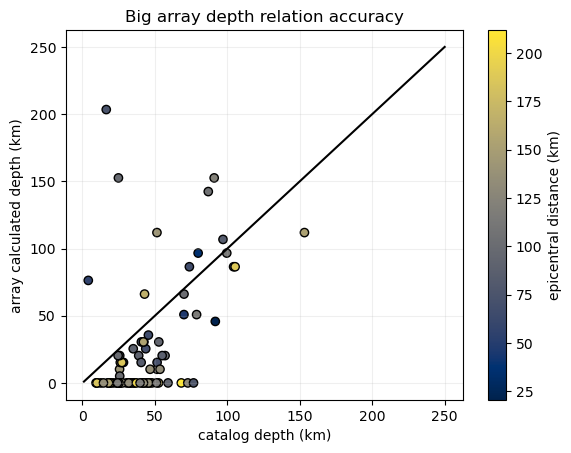

In [132]:
fig,ax = plt.subplots()

sc = ax.scatter(dep_df['earthquake_depth'], dep_df['estimated_depth'], c=dep_df['distance'], cmap = 'cividis',  edgecolors = 'black')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.plot(np.linspace(1, 250, 200), np.linspace(1, 250, 200), color = 'black')

ax.grid(alpha = 0.2)
ax.set_xlabel('catalog depth (km)')
ax.set_ylabel('array calculated depth (km)')
ax.set_title('Big array depth relation accuracy')

plt.show()

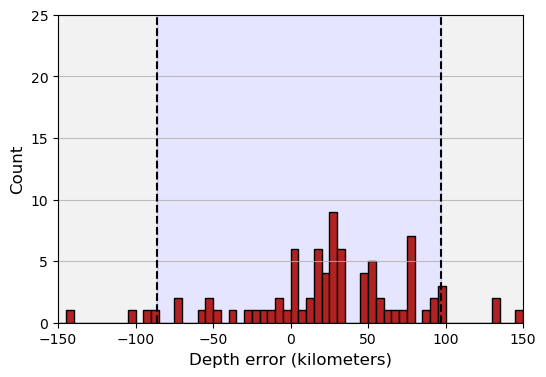

183.15393220338981


In [133]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
corrected = dep_df['depth_error'].to_numpy()
#corrected =  dep_df['earthquake_depth'].to_numpy()-dep_df['estimated_depth_homog'].to_numpy()

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('Depth error (kilometers)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-150, 150)
ax.set_ylim(0, 25)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('ls_histogram_timing_ssa.png', transparent=True, dpi = 720)
plt.show()
print(range1)

### Making japan velocity model

In [20]:
import numpy as np
jap_dep = df['dep'].to_numpy()
density = []
for i in range(len(df)):
    depth_jap = jap_dep[i]
    

    target = depth_jap
    arr = df2['depth'].to_numpy()

    idx = np.abs(arr - target).argmin()
    closest = df1['density'].to_numpy()[idx]
    density.append(closest)



        
    

In [25]:
np.array(density)
df['density'] = density
df = df.reindex(columns=["dep", "pvel", "svel","density"])
df.to_csv("japan_1d.tvel", sep="\t", index=False)



In [12]:
df1 = pd.read_csv('/Users/cadequigley/Downloads/test_japan.txt')
df2 = pd.read_csv('/Users/cadequigley/Downloads/test_depth.txt')

In [18]:
df1['depth'] = df2['depth']
df1

,density,depth
0,2.7200,0.0
1,2.7200,20.0
2,2.9200,20.0
3,2.9200,35.0
4,3.3198,35.0
5,3.3455,77.5
6,3.3713,120.0
7,3.3985,165.0
8,3.4258,210.0
9,3.4258,210.0


In [14]:
df2

,depth
0,0.0
1,20.0
2,20.0
3,35.0
4,35.0
5,77.5
6,120.0
7,165.0
8,210.0
9,210.0


In [27]:
from obspy.taup import taup_create
taup_create.build_taup_model("/Users/cadequigley/Downloads/Research/paper_figures/japan_1d.tvel")
#model = TauPyModel(model="pavdut")

Building obspy.taup model for '/Users/cadequigley/Downloads/Research/paper_figures/japan_1d.tvel' ...
filename = /Users/cadequigley/Downloads/Research/paper_figures/japan_1d.tvel
Done reading velocity model.
Radius of model  is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  3728 P layers,4129 S layers
Done calculating Tau branches.
Done Saving /Users/cadequigley/miniconda3/envs/pygmt/lib/python3.9/site-packages/obspy/taup/data/japan_1d.npz
Method run is done, but not necessarily successful.


In [31]:
model = TauPyModel(model="japan_1d")

In [29]:
from obspy.taup import TauPyModel